## Referencias

* https://www.ufrgs.br/wiki-r/index.php?title=Data_Frame

In [1]:
library(dplyr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [2]:
# Adicionando o diretorio atual
setwd("../");

In [3]:
dataset <- read.csv(file="./summer-products-with-rating-and-performance_2020-08.csv", header=TRUE, sep=",")
dataset <- as.data.frame(dataset)

In [4]:
base <- select(dataset, price, units_sold, rating, rating_count, retail_price)

In [5]:
cor(base)

,price,units_sold,rating,rating_count,retail_price
price,1.000000000,-0.02481474,0.05346852,-0.001910505,0.30474760
units_sold,-0.024814738,1.00000000,0.03947825,0.899463652,0.01263839
rating,0.053468521,0.03947825,1.00000000,0.054112293,0.02410629
rating_count,-0.001910505,0.89946365,0.05411229,1.000000000,0.05387161
retail_price,0.304747605,0.01263839,0.02410629,0.053871605,1.00000000


In [6]:
modelo1var <- lm(base$units_sold ~ base$price)
summary(modelo1var)


Call:
lm(formula = base$units_sold ~ base$price)

Residuals:
   Min     1Q Median     3Q    Max 
 -4722  -4258  -3417    701  95642 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4830.60     552.56   8.742   <2e-16 ***
base$price    -59.05      60.02  -0.984    0.325    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9357 on 1571 degrees of freedom
Multiple R-squared:  0.0006158,	Adjusted R-squared:  -2.037e-05 
F-statistic: 0.968 on 1 and 1571 DF,  p-value: 0.3253


In [7]:
anova(modelo1var)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
base$price,1,84742724,84742724,0.9679726,0.3253378
Residuals,1571,137535726438,87546611,NA,NA


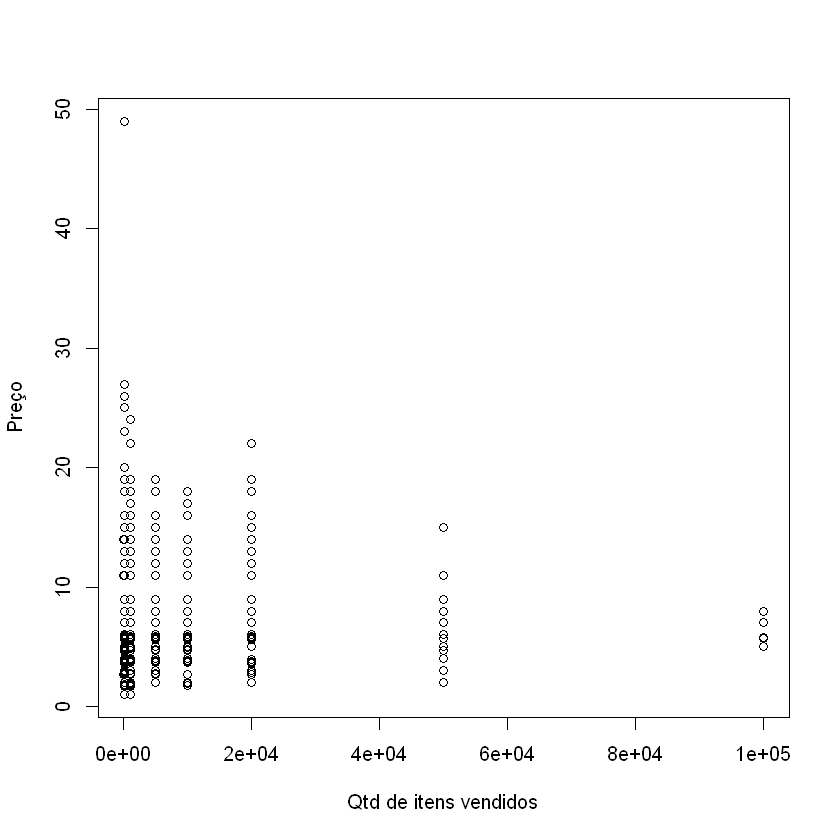

In [8]:
plot(x=base$units_sold, y=base$price, xlab="Qtd de itens vendidos", ylab="Preço")

In [9]:
modelo2var <- lm(base$units_sold ~ base$price + base$rating)
summary(modelo2var)


Call:
lm(formula = base$units_sold ~ base$price + base$rating)

Residuals:
   Min     1Q Median     3Q    Max 
 -5574  -4102  -3376    744  95706 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  2035.28    1810.73   1.124    0.261
base$price    -64.25      60.07  -1.070    0.285
base$rating   742.93     458.32   1.621    0.105

Residual standard error: 9352 on 1570 degrees of freedom
Multiple R-squared:  0.002286,	Adjusted R-squared:  0.001015 
F-statistic: 1.798 on 2 and 1570 DF,  p-value: 0.1659
